<a href="https://colab.research.google.com/github/Gab2697/Surface-classification-IMU/blob/main/CNN_python/CNN_SurfaceClassification_IMU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORT AND FUNCTIONS

In [3]:
#import
import pandas as pd
import tensorflow as tf
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.io import loadmat

from keras import layers 
from keras import models
from keras import regularizers
import glob

from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#================================mat to tensor================================
def mat_to_tensor(path_mat):
  data=loadmat(path_mat)
  keys=list(data['data'].dtype.fields.keys())
  da=np.array(data['data'][keys[0]])
  for i in range(1,len(keys)-2):
      da=np.append(da,data['data'][keys[i]],axis=1)
  da=np.append(da,data['data'][keys[-2]],axis=1)
  da=np.append(da,data['data'][keys[-1]],axis=1)
  da=pd.DataFrame(da,columns=keys)
  Participant= da['Subject']
  Surface= da['Conditions'] 
  # from 2d to 3d
  Ndata=da
  Parameters=Ndata.keys()
  GC_len=Ndata.iloc[1,1].shape[0]
  data1=np.zeros([Ndata.shape[0],GC_len,len(Parameters)-2])
  for i in range(len(Parameters)-2):
    for j in range(len(Ndata[Parameters[i]])):
      data1[j,:,i]=Ndata[Parameters[i]].to_numpy()[j].reshape(GC_len)
  return data1,Participant,Surface,Parameters

#================================Save pickle file================================
def save_pickle(path_pickle,T):
    f = open(path_pickle, 'wb')
    pickle.dump(T, f)
    f.close()

    return f 

#================================Open pickle file================================
def open_pickle(path_pickle):
    f = open(path_pickle, 'rb')
    T = pickle.load(f)
    f.close()

    return T


#================================subject wise split================================

def subject_wise_split(Participant,subject_wise,split=0.10,seed=42):
    np.random.seed(seed)
    if subject_wise:
        UniqParti=np.unique(Participant)
        num=np.round(UniqParti.shape[0]*split).astype('int64')
        np.random.shuffle(UniqParti)
        extract=UniqParti[0:num]
        test_index=np.array([],dtype='int64')
        for j in extract:
            test_index=np.append(test_index,np.where(Participant==j)[0])
        train_index=np.delete(np.arange(len(Participant)),test_index)
        np.random.shuffle(test_index)
        np.random.shuffle(train_index)

    else:
        I=np.arange(len(Participant)).astype('int64')
        np.random.shuffle(I)
        num=np.round(Participant.shape[0]*split).astype('int64')
        test_index=I[0:num]
        train_index=I[num:]
        extract=np.unique(Participant[test_index])
    return train_index,test_index
#================================One Hot encoding================================
def one_hot(y):
    uniq=np.unique(y)
    y_hot=np.zeros([y.shape[0],uniq.shape[0]])
    for i in range(len(uniq)):
        index=np.where(y==uniq[i])[0]
        y_hot[index,i]=1
    surface_name=uniq
    return y_hot

#================================final prep CNN================================
def final_prep(data, Surface, Participant, True_False):
  #test set
  train_index1,test_index=subject_wise_split(np.array(Participant),split=0.10,subject_wise= True_False,seed=5)
  train_index1,test_index=train_index1.astype('int64'),test_index.astype('int64')   
  X_train1=data[train_index1]
  X_test=data[test_index]
  y_train1=Surface[train_index1]
  label_test=Surface[test_index]

  #validation set
  ALL_Participants_train=Participant[train_index1]
  train_index,validation_index=subject_wise_split(np.array(ALL_Participants_train),split=0.20,subject_wise= True_False,seed=5)
  train_index,validation_index=train_index.astype('int64'),validation_index.astype('int64')  
  X_train=X_train1[train_index]
  X_validation=X_train1[validation_index]
  y_train=y_train1[train_index]
  y_validation=y_train1[validation_index]

  #tensor shape
  print("Tensor train shape:", X_train.shape)
  print("Tensor validation shape:", X_validation.shape)
  print("Tensor test shape:", X_test.shape)

  #one hot encoding for label
  X_train=np.asarray(X_train).astype(np.float32) 
  y_train=one_hot(y_train)
  X_test=np.asarray(X_test).astype(np.float32) 
  y_test=one_hot(label_test)
  X_validation=np.asarray(X_validation).astype(np.float32)
  y_validation=one_hot(y_validation)
  return X_train,y_train,X_test,y_test,X_validation, y_validation

# 1. IMPACT OF PRE-PROCESSING STEPS

## 1.1 SIGNAL SEPERATION

using the lower body combination of sensor for this section with the following model and epoch=100, batch size=200

In [11]:
def CNN_test(input_shape,output_shape):
    model = tf.keras.models.Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
    return model

### FULL TRIAL (4 SEC)- NO GC

only once

this is for both acc and gyro lower body for 4 sec trials

In [ ]:
data,Participant,Surface,Parameters=mat_to_tensor('/content/drive/MyDrive/Gab/mat files/imu_only/acc_gyro_4sec_LB_merge.mat')

In [ ]:
#save
LB_data_4sec=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/IMU/LB_data_4sec.pkl',data)
LB_Surfaces_4sec=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/IMU/LB_Surfaces_4sec.pkl',Surface)
LB_Participants_numb_4sec=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/IMU/LB_Participants_numb_4sec.pkl',Participant)
Parameters_4sec=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/IMU/LB_Parameters_4sec.pkl',Parameters)

everytime

In [ ]:
LB_data_4sec=open_pickle('/content/drive/MyDrive/Gab/Variables_saved/IMU/LB_data_4sec.pkl')
LB_Parameters_4sec=open_pickle('/content/drive/MyDrive/Gab/Variables_saved/IMU/LB_Parameters_4sec.pkl')
LB_Surfaces_4sec=open_pickle('/content/drive/MyDrive/Gab/Variables_saved/IMU/LB_Surfaces_4sec.pkl')
LB_Participants_numb_4sec=open_pickle('/content/drive/MyDrive/Gab/Variables_saved/IMU/LB_Participants_numb_4sec.pkl')

In [ ]:
#================================Seperate acceleration locations================================
def seperate_signals(type_signal,ALL_data):
  if type_signal=='pelvis_acc':
    ALL_data=ALL_data[:,:,0:3]
  elif type_signal=='right_upper_leg_acc':
    ALL_data=ALL_data[:,:,3:6]
  elif type_signal=='right_lower_leg_acc':
    ALL_data=ALL_data[:,:,6:9]
  elif type_signal=='right_foot_acc':
    ALL_data=ALL_data[:,:,9:12]
  elif type_signal=='left_upper_leg_acc':
    ALL_data=ALL_data[:,:,12:15]
  elif type_signal=='left_lower_leg_acc':
    ALL_data=ALL_data[:,:,15:18]
  elif type_signal=='left_foot_acc':
    ALL_data=ALL_data[:,:,18:21]

  elif type_signal=='pelvis_gyro':
    ALL_data=ALL_data[:,:,21:24]
  elif type_signal=='right_lower_leg_gyro':
    ALL_data=ALL_data[:,:,24:27]
  elif type_signal=='right_foot_gyro':
    ALL_data=ALL_data[:,:,27:30]
  elif type_signal=='left_upper_leg_gyro':
    ALL_data=ALL_data[:,:,30:33]
  elif type_signal=='left_lower_leg_gyro':
    ALL_data=ALL_data[:,:,33:36]
  elif type_signal=='left_foot_gyro':
    ALL_data=ALL_data[:,:,36:39]
  return ALL_data

#### acceleration

In [ ]:
ALL_data_acc_LF_4sec=seperate_signals('left_foot_acc',LB_data_4sec)
ALL_data_acc_LLL_4sec=seperate_signals('left_lower_leg_acc',LB_data_4sec)
ALL_data_acc_RF_4sec=seperate_signals('right_foot_acc',LB_data_4sec)
ALL_data_acc_RLL_4sec=seperate_signals('right_lower_leg_acc',LB_data_4sec)
ALL_data_acc_pelvis_4sec=seperate_signals('pelvis_acc',LB_data_4sec)

ALL_data_LowerBody_4sec_acc= tf.concat([ALL_data_acc_LF_4sec,ALL_data_acc_RF_4sec,ALL_data_acc_LLL_4sec,ALL_data_acc_RLL_4sec,ALL_data_acc_pelvis_4sec], axis=2)

In [ ]:
#seperate train,validation and test set for EMG raw data 
X_train,y_train,X_test,y_test,X_validation, y_validation=final_prep(ALL_data_LowerBody_4sec_acc.numpy(), LB_Surfaces_4sec.to_numpy(), LB_Participants_numb_4sec.to_numpy(),False)

Tensor train shape: (4415, 961, 15)
Tensor validation shape: (1104, 961, 15)
Tensor test shape: (613, 961, 15)


In [ ]:
model=CNN_test(X_train.shape[1:],2) 
history= model.fit(X_train,y_train, epochs=100, batch_size=200,validation_data=(X_validation, y_validation))

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


23/23 [==============================] - 21s 870ms/step - loss: 13.3871 - accuracy: 0.4907 - val_loss: 0.6924 - val_accuracy: 0.5132
Epoch 2/100
23/23 [==============================] - 19s 833ms/step - loss: 0.6929 - accuracy: 0.4980 - val_loss: 0.6927 - val_accuracy: 0.5132
Epoch 3/100
23/23 [==============================] - 19s 810ms/step - loss: 0.6924 - accuracy: 0.4980 - val_loss: 0.6929 - val_accuracy: 0.5132
Epoch 4/100
23/23 [==============================] - 19s 838ms/step - loss: 0.6910 - accuracy: 0.5107 - val_loss: 0.6933 - val_accuracy: 0.4886
Epoch 5/100
23/23 [==============================] - 19s 805ms/step - loss: 0.6891 - accuracy: 0.5184 - val_loss: 0.6938 - val_accuracy: 0.4932
Epoch 6/100
23/23 [==============================] - 19s 808ms/step - loss: 0.6867 - accuracy: 0.5277 - val_loss: 0.6947 - val_accuracy: 0.4923
Epoch 7/100
23/23 [==============================] - 19s 840ms/step - loss: 0.6831 - accuracy: 0.5402 - val_loss: 0.6943 - val_accuracy: 0.4877
Epo

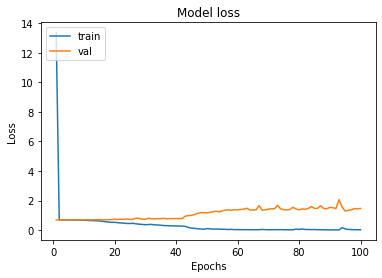

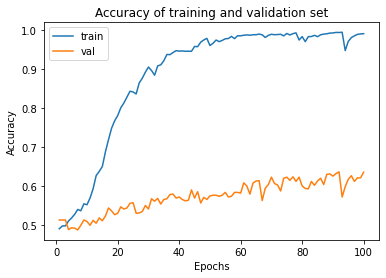

In [ ]:
#plot train/validation loss and train/validation accuracy 
history_dict = history.history
loss_values=history_dict['loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs,history_dict['loss'])
plt.plot(epochs, history_dict['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

accuracy_values = history_dict['accuracy']
val_accuracy= history_dict['val_accuracy']
plt.plot(epochs, accuracy_values)
plt.plot(epochs, val_accuracy)
plt.title('Accuracy of training and validation set') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### angular velocity

In [ ]:
ALL_data_gyro_LF_4sec=seperate_signals('left_foot_gyro',LB_data_4sec)
ALL_data_gyro_LLL_4sec=seperate_signals('left_lower_leg_gyro',LB_data_4sec)
ALL_data_gyro_RF_4sec=seperate_signals('right_foot_gyro',LB_data_4sec)
ALL_data_gyro_RLL_4sec=seperate_signals('right_lower_leg_gyro',LB_data_4sec)
ALL_data_gyro_pelvis_4sec=seperate_signals('pelvis_gyro',LB_data_4sec)

ALL_data_LowerBody_4sec_gyro= tf.concat([ALL_data_gyro_LF_4sec,ALL_data_gyro_RF_4sec,ALL_data_gyro_LLL_4sec,ALL_data_gyro_RLL_4sec,ALL_data_gyro_pelvis_4sec], axis=2)

In [ ]:
#seperate train,validation and test set for EMG raw data 
X_train,y_train,X_test,y_test,X_validation, y_validation=final_prep(ALL_data_LowerBody_4sec_gyro.numpy(), LB_Surfaces_4sec.to_numpy(), LB_Participants_numb_4sec.to_numpy(),False)

Tensor train shape: (4402, 961, 15)
Tensor validation shape: (1101, 961, 15)
Tensor test shape: (611, 961, 15)


In [ ]:
model=CNN_test(X_train.shape[1:],2) 
history= model.fit(X_train,y_train, epochs=100, batch_size=200,validation_data=(X_validation, y_validation))

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


23/23 [==============================] - 21s 857ms/step - loss: 5.0001 - accuracy: 0.5066 - val_loss: 0.6931 - val_accuracy: 0.5132
Epoch 2/100
23/23 [==============================] - 18s 789ms/step - loss: 0.6932 - accuracy: 0.4980 - val_loss: 0.6931 - val_accuracy: 0.5132
Epoch 3/100
23/23 [==============================] - 19s 821ms/step - loss: 0.6932 - accuracy: 0.4980 - val_loss: 0.6931 - val_accuracy: 0.5132
Epoch 4/100
23/23 [==============================] - 18s 794ms/step - loss: 0.6931 - accuracy: 0.4980 - val_loss: 0.6933 - val_accuracy: 0.5132
Epoch 5/100
23/23 [==============================] - 18s 791ms/step - loss: 0.6929 - accuracy: 0.4980 - val_loss: 0.6939 - val_accuracy: 0.5132
Epoch 6/100
23/23 [==============================] - 20s 878ms/step - loss: 0.6911 - accuracy: 0.5036 - val_loss: 0.6943 - val_accuracy: 0.4977
Epoch 7/100
23/23 [==============================] - 18s 790ms/step - loss: 0.6837 - accuracy: 0.5366 - val_loss: 0.6939 - val_accuracy: 0.4986
Epoc

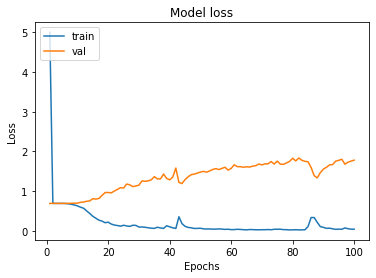

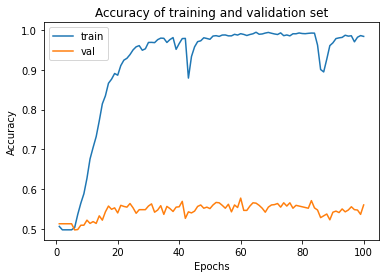

In [ ]:
#plot train/validation loss and train/validation accuracy 
history_dict = history.history
loss_values=history_dict['loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs,history_dict['loss'])
plt.plot(epochs, history_dict['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

accuracy_values = history_dict['accuracy']
val_accuracy= history_dict['val_accuracy']
plt.plot(epochs, accuracy_values)
plt.plot(epochs, val_accuracy)
plt.title('Accuracy of training and validation set') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### DATA SEPERATED IN GC (FROM MERGED WITH EMG)

only do once

In [ ]:
#acc and EMG
data,Participant,Surface,Parameters=mat_to_tensor('/content/drive/MyDrive/Gab/mat files/merge/Good_version_ no sweat/EMG_acc_noS_good_version.mat')
print("Tensor all acc and emg shape:", data.shape)

Tensor all acc and emg shape: (28289, 101, 72)


In [ ]:
#gyro
data_gyro,Participant,Surface,Parameters_gyro=mat_to_tensor('/content/drive/MyDrive/Gab/mat files/merge/Good_version_ no sweat/gyro_good_version_noS.mat')
print("Tensor all gyro shape:", data_gyro.shape)

In [ ]:
#seperate acc and EMG
#================================Seperate signals from IMU data================================
def seperate_signals(type_signal,ALL_data):
  if type_signal=='acc':
    ALL_data=ALL_data[:,:,0:48]
  elif type_signal=='EMG':
    ALL_data=ALL_data[:,:,48:-2]

  return ALL_data
  
data_acc=seperate_signals('acc',data)
Parameters_acc=Parameters[0:48]

In [ ]:
#save
ALL_data_acc=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/merged/Good_version/ALL_data_acc_GC_noS.pkl',data_acc)
# ALL_data_gyro=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/merged/Good_version/ALL_data_gyro_GC_noS.pkl',data_gyro)
ALL_Surfaces=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/merged/Good_version/ALL_Surfaces.pkl',Surface)
ALL_Participants_numb=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/merged/Good_version/ALL_Participants_numb.pkl',Participant)
Parameters_acc=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/merged/Good_version/ALL_Parameters_acc.pkl',Parameters_acc)
# Parameters_gyro=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/merged/Good_version/ALL_Parameters_gyro.pkl',Parameters_gyro)

everytime

#### acceleration

In [6]:
ALL_data_acc=open_pickle('/content/drive/MyDrive/Gab/Variables_saved/merged/Good_version/ALL_data_acc_GC_noS.pkl')
Parameters_acc=open_pickle('/content/drive/MyDrive/Gab/Variables_saved/merged/Good_version/ALL_Parameters_acc.pkl')
ALL_Surfaces=open_pickle('/content/drive/MyDrive/Gab/Variables_saved/merged/Good_version/ALL_Surfaces.pkl')
ALL_Participants_numb=open_pickle('/content/drive/MyDrive/Gab/Variables_saved/merged/Good_version/ALL_Participants_numb.pkl')

In [7]:
#================================Seperate acceleration locations================================
def seperate_Acc_signals(type_signal,ALL_data):
  if type_signal=='pelvis':
    ALL_data=ALL_data[:,:,0:3]
  elif type_signal=='head':
    ALL_data=ALL_data[:,:,3:6]
  elif type_signal=='right_shoulder':
    ALL_data=ALL_data[:,:,6:9]
  elif type_signal=='right_hand':
    ALL_data=ALL_data[:,:,15:18]
  elif type_signal=='left_hand':
    ALL_data=ALL_data[:,:,27:30]
  elif type_signal=='left_shoulder':
    ALL_data=ALL_data[:,:,30:33]
  elif type_signal=='right_lower_leg':
    ALL_data=ALL_data[:,:,33:36]
  elif type_signal=='right_foot':
    ALL_data=ALL_data[:,:,36:39]
  elif type_signal=='left_lower_leg':
    ALL_data=ALL_data[:,:,42:45]
  elif type_signal=='left_foot':
    ALL_data=ALL_data[:,:,45:48]
  return ALL_data

In [8]:
ALL_data_acc_LF=seperate_Acc_signals('left_foot',ALL_data_acc)
ALL_data_acc_LLL=seperate_Acc_signals('left_lower_leg',ALL_data_acc)
ALL_data_acc_RF=seperate_Acc_signals('right_foot',ALL_data_acc)
ALL_data_acc_RLL=seperate_Acc_signals('right_lower_leg',ALL_data_acc)
ALL_data_acc_pelvis=seperate_Acc_signals('pelvis',ALL_data_acc)

ALL_data_LowerBody= tf.concat([ALL_data_acc_LF,ALL_data_acc_RF,ALL_data_acc_LLL,ALL_data_acc_RLL,ALL_data_acc_pelvis], axis=2)

In [9]:
#seperate train,validation and test set 
X_train,y_train,X_test,y_test,X_validation, y_validation=final_prep(ALL_data_LowerBody.numpy(), ALL_Surfaces.to_numpy(), ALL_Participants_numb.to_numpy(),False)

Tensor train shape: (20368, 101, 15)
Tensor validation shape: (5092, 101, 15)
Tensor test shape: (2829, 101, 15)


In [ ]:
model=CNN_test(X_train.shape[1:],2) 
history= model.fit(X_train,y_train, epochs=100, batch_size=200,validation_data=(X_validation, y_validation))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
102/102 [==============================] - 14s 120ms/step - loss: 1.3947 - accuracy: 0.5209 - val_loss: 0.6870 - val_accuracy: 0.5495
Epoch 2/100
102/102 [==============================] - 10s 100ms/step - loss: 0.6807 - accuracy: 0.5651 - val_loss: 0.6706 - val_accuracy: 0.6019
Epoch 3/100
102/102 [==============================] - 11s 110ms/step - loss: 0.6474 - accuracy: 0.6205 - val_loss: 0.6160 - val_accuracy: 0.6679
Epoch 4/100
102/102 [==============================] - 14s 138ms/step - loss: 0.5865 - accuracy: 0.6882 - val_loss: 0.5529 - val_accuracy: 0.7247
Epoch 5/100
102/102 [==============================] - 9s 92ms/step - loss: 0.5200 - accuracy: 0.7373 - val_loss: 0.4858 - val_accuracy: 0.7836
Epoch 6/100
102/102 [==============================] - 9s 93ms/step - loss: 0.4621 - accuracy: 0.7806 - val_loss: 0.4329 - val_accuracy: 0.8138
Epoch 7/100
102/102 [==============================] - 9s 93ms/step - loss: 0.4332 - accuracy: 0.7957 - val_loss: 0.3951 - val_a

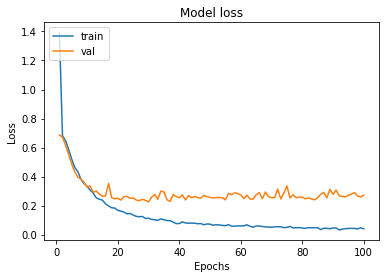

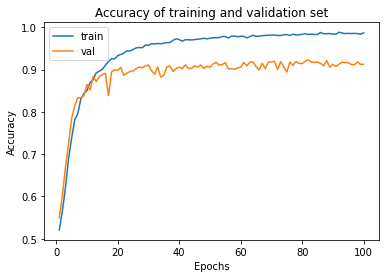

In [ ]:
#plot train/validation loss and train/validation accuracy 
history_dict = history.history
loss_values=history_dict['loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs,history_dict['loss'])
plt.plot(epochs, history_dict['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

accuracy_values = history_dict['accuracy']
val_accuracy= history_dict['val_accuracy']
plt.plot(epochs, accuracy_values)
plt.plot(epochs, val_accuracy)
plt.title('Accuracy of training and validation set') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

####angular velocity

In [ ]:
ALL_data_gyro=open_pickle('/content/drive/MyDrive/Gab/Variables_saved/merged/Good_version/ALL_data_gyro_GC_noS.pkl')
Parameters_gyro=open_pickle('/content/drive/MyDrive/Gab/Variables_saved/merged/Good_version/ALL_Parameters_gyro.pkl')
ALL_Surfaces=open_pickle('/content/drive/MyDrive/Gab/Variables_saved/merged/Good_version/ALL_Surfaces.pkl')
ALL_Participants_numb=open_pickle('/content/drive/MyDrive/Gab/Variables_saved/merged/Good_version/ALL_Participants_numb.pkl')

In [ ]:
#================================Seperate gyro locations================================
def seperate_Gyro_signals(type_signal,ALL_data): #seven sensors
  if type_signal=='pelvis':
    ALL_data=ALL_data[:,:,0:3]
  elif type_signal=='right_shoulder':
    ALL_data=ALL_data[:,:,3:6]
  elif type_signal=='right_hand':
    ALL_data=ALL_data[:,:,9:12]
  elif type_signal=='left_shoulder':
    ALL_data=ALL_data[:,:,12:15]
  elif type_signal=='left_hand':
    ALL_data=ALL_data[:,:,18:21]
  elif type_signal=='right_lower_leg':
    ALL_data=ALL_data[:,:,21:24]
  elif type_signal=='right_foot':
    ALL_data=ALL_data[:,:,24:27]
  elif type_signal=='left_lower_leg':
    ALL_data=ALL_data[:,:,30:33]
  elif type_signal=='left_foot':
    ALL_data=ALL_data[:,:,33:36]
  return ALL_data

In [ ]:
pelvis_gyro=seperate_Gyro_signals('pelvis',ALL_data_gyro)
RLL_gyro=seperate_Gyro_signals('right_lower_leg',ALL_data_gyro)
LLL_gyro=seperate_Gyro_signals('left_lower_leg',ALL_data_gyro)
LF_gyro=seperate_Gyro_signals('right_foot',ALL_data_gyro)
RF_gyro=seperate_Gyro_signals('right_lower_leg',ALL_data_gyro)

Lower_body_gyro= tf.concat([pelvis_gyro,RLL_gyro,LLL_gyro,LF_gyro,RF_gyro], axis=2)

In [ ]:
X_train,y_train,X_test,y_test,X_validation, y_validation=final_prep(Lower_body_gyro.numpy(), ALL_Surfaces.to_numpy(), ALL_Participants_numb.to_numpy(),False)

Tensor train shape: (20368, 101, 15)
Tensor validation shape: (5092, 101, 15)
Tensor test shape: (2829, 101, 15)


In [ ]:
model=CNN_test(X_train.shape[1:],2) 
history= model.fit(X_train,y_train, epochs=100, batch_size=200,validation_data=(X_validation, y_validation))

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


102/102 [==============================] - 16s 142ms/step - loss: 0.7690 - accuracy: 0.5369 - val_loss: 0.6801 - val_accuracy: 0.5854
Epoch 2/100
102/102 [==============================] - 10s 95ms/step - loss: 0.6610 - accuracy: 0.5975 - val_loss: 0.6478 - val_accuracy: 0.6231
Epoch 3/100
102/102 [==============================] - 12s 114ms/step - loss: 0.6121 - accuracy: 0.6644 - val_loss: 0.5993 - val_accuracy: 0.6868
Epoch 4/100
102/102 [==============================] - 18s 176ms/step - loss: 0.5624 - accuracy: 0.7038 - val_loss: 0.5749 - val_accuracy: 0.7011
Epoch 5/100
102/102 [==============================] - 10s 100ms/step - loss: 0.5278 - accuracy: 0.7321 - val_loss: 0.5374 - val_accuracy: 0.7317
Epoch 6/100
102/102 [==============================] - 10s 94ms/step - loss: 0.4842 - accuracy: 0.7626 - val_loss: 0.5148 - val_accuracy: 0.7419
Epoch 7/100
102/102 [==============================] - 10s 93ms/step - loss: 0.4534 - accuracy: 0.7817 - val_loss: 0.4804 - val_accuracy: 

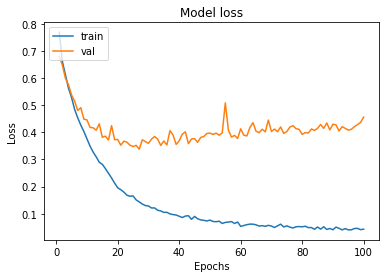

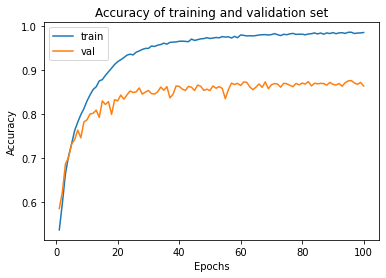

In [ ]:
#plot train/validation loss and train/validation accuracy 
history_dict = history.history
loss_values=history_dict['loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs,history_dict['loss'])
plt.plot(epochs, history_dict['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

accuracy_values = history_dict['accuracy']
val_accuracy= history_dict['val_accuracy']
plt.plot(epochs, accuracy_values)
plt.plot(epochs, val_accuracy)
plt.title('Accuracy of training and validation set') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## 1.2 IMPACT OF NORMALIZATION

norm with data from merged

only do once

In [ ]:
data,Participant,Surface,Parameters=mat_to_tensor('/content/drive/MyDrive/Gab/mat files/imu_only/acc_gyro_LB_GC_norm_cut.mat')

In [ ]:
# save
ALL_data_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/IMU/ALL_data_GC_norm.pkl',data)
ALL_Surfaces_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/IMU/ALL_Surfaces_norm.pkl',Surface)
ALL_Participants_numb_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/IMU/ALL_Participants_numb_norm.pkl',Participant)
Parameters_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/IMU/ALL_Parameters_norm.pkl',Parameters)

everytime

In [13]:
ALL_data_norm=open_pickle('/content/drive/MyDrive/Gab/Variables_saved/IMU/ALL_data_GC_norm.pkl')
Parameters_norm=open_pickle('/content/drive/MyDrive/Gab/Variables_saved/IMU/ALL_Parameters_norm.pkl')
ALL_Surfaces_norm=open_pickle('/content/drive/MyDrive/Gab/Variables_saved/IMU/ALL_Surfaces_norm.pkl')
ALL_Participants_numb_norm=open_pickle('/content/drive/MyDrive/Gab/Variables_saved/IMU/ALL_Participants_numb_norm.pkl')

In [14]:
#================================Seperate acceleration locations================================
def seperate_signals(type_signal,ALL_data):
  if type_signal=='pelvis_acc':
    ALL_data=ALL_data[:,:,0:3]
  elif type_signal=='right_upper_leg_acc':
    ALL_data=ALL_data[:,:,3:6]
  elif type_signal=='right_lower_leg_acc':
    ALL_data=ALL_data[:,:,6:9]
  elif type_signal=='right_foot_acc':
    ALL_data=ALL_data[:,:,9:12]
  elif type_signal=='left_upper_leg_acc':
    ALL_data=ALL_data[:,:,12:15]
  elif type_signal=='left_lower_leg_acc':
    ALL_data=ALL_data[:,:,15:18]
  elif type_signal=='left_foot_acc':
    ALL_data=ALL_data[:,:,18:21]

  elif type_signal=='pelvis_gyro':
    ALL_data=ALL_data[:,:,21:24]
  elif type_signal=='right_lower_leg_gyro':
    ALL_data=ALL_data[:,:,24:27]
  elif type_signal=='right_foot_gyro':
    ALL_data=ALL_data[:,:,27:30]
  elif type_signal=='left_upper_leg_gyro':
    ALL_data=ALL_data[:,:,30:33]
  elif type_signal=='left_lower_leg_gyro':
    ALL_data=ALL_data[:,:,33:36]
  elif type_signal=='left_foot_gyro':
    ALL_data=ALL_data[:,:,36:39]
  return ALL_data

### aceleration

In [15]:
ALL_data_acc_LF_norm=seperate_signals('left_foot_acc',ALL_data_norm)
ALL_data_acc_LLL_norm=seperate_signals('left_lower_leg_acc',ALL_data_norm)
ALL_data_acc_RF_norm=seperate_signals('right_foot_acc',ALL_data_norm)
ALL_data_acc_RLL_norm=seperate_signals('right_lower_leg_acc',ALL_data_norm)
ALL_data_acc_pelvis_norm=seperate_signals('pelvis_acc',ALL_data_norm)

ALL_data_LowerBody_norm_acc= tf.concat([ALL_data_acc_LF_norm,ALL_data_acc_RF_norm,ALL_data_acc_LLL_norm,ALL_data_acc_RLL_norm,ALL_data_acc_pelvis_norm], axis=2)

In [16]:
#seperate train,validation and test set for EMG raw data 
X_train,y_train,X_test,y_test,X_validation, y_validation=final_prep(ALL_data_LowerBody_norm_acc.numpy(), ALL_Surfaces_norm.to_numpy(), ALL_Participants_numb_norm.to_numpy(),False)

Tensor train shape: (20348, 101, 15)
Tensor validation shape: (5087, 101, 15)
Tensor test shape: (2826, 101, 15)


In [ ]:
model=CNN_test(X_train.shape[1:],2) 
history= model.fit(X_train,y_train, epochs=100, batch_size=200,validation_data=(X_validation, y_validation))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
102/102 [==============================] - 11s 92ms/step - loss: 0.6667 - accuracy: 0.5879 - val_loss: 0.6333 - val_accuracy: 0.6523
Epoch 2/100
102/102 [==============================] - 9s 91ms/step - loss: 0.5865 - accuracy: 0.6889 - val_loss: 0.5623 - val_accuracy: 0.7069
Epoch 3/100
102/102 [==============================] - 9s 90ms/step - loss: 0.5150 - accuracy: 0.7412 - val_loss: 0.5003 - val_accuracy: 0.7694
Epoch 4/100
102/102 [==============================] - 9s 91ms/step - loss: 0.4652 - accuracy: 0.7771 - val_loss: 0.5045 - val_accuracy: 0.7429
Epoch 5/100
102/102 [==============================] - 9s 90ms/step - loss: 0.4247 - accuracy: 0.8044 - val_loss: 0.4343 - val_accuracy: 0.8024
Epoch 6/100
102/102 [==============================] - 9s 89ms/step - loss: 0.3883 - accuracy: 0.8224 - val_loss: 0.3999 - val_accuracy: 0.8231
Epoch 7/100
102/102 [==============================] - 9s 90ms/step - loss: 0.3684 - accuracy: 0.8344 - val_loss: 0.3839 - val_accuracy

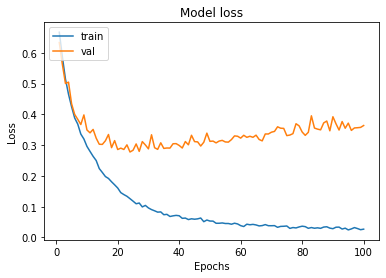

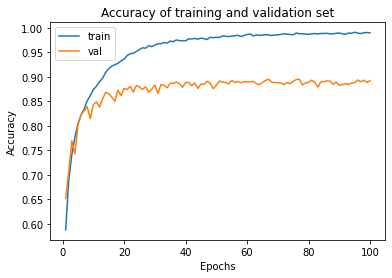

In [ ]:
#plot train/validation loss and train/validation accuracy 
history_dict = history.history
loss_values=history_dict['loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs,history_dict['loss'])
plt.plot(epochs, history_dict['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

accuracy_values = history_dict['accuracy']
val_accuracy= history_dict['val_accuracy']
plt.plot(epochs, accuracy_values)
plt.plot(epochs, val_accuracy)
plt.title('Accuracy of training and validation set') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### angular velocity

In [ ]:
ALL_data_gyro_LF_norm=seperate_signals('left_foot_gyro',ALL_data_norm)
ALL_data_gyro_LLL_norm=seperate_signals('left_lower_leg_gyro',ALL_data_norm)
ALL_data_gyro_RF_norm=seperate_signals('right_foot_gyro',ALL_data_norm)
ALL_data_gyro_RLL_norm=seperate_signals('right_lower_leg_gyro',ALL_data_norm)
ALL_data_gyro_pelvis_norm=seperate_signals('pelvis_gyro',ALL_data_norm)

ALL_data_LowerBody_norm_gyro= tf.concat([ALL_data_gyro_LF_norm,ALL_data_gyro_RF_norm,ALL_data_gyro_LLL_norm,ALL_data_gyro_RLL_norm,ALL_data_gyro_pelvis_norm], axis=2)

In [ ]:
#seperate train,validation and test set for EMG raw data 
X_train,y_train,X_test,y_test,X_validation, y_validation=final_prep(ALL_data_LowerBody_norm_gyro.numpy(), ALL_Surfaces_norm.to_numpy(), ALL_Participants_numb_norm.to_numpy(),False)

Tensor train shape: (20348, 101, 15)
Tensor validation shape: (5087, 101, 15)
Tensor test shape: (2826, 101, 15)


In [ ]:
model=CNN_test(X_train.shape[1:],2) 
history= model.fit(X_train,y_train, epochs=100, batch_size=200,validation_data=(X_validation, y_validation))

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


102/102 [==============================] - 13s 123ms/step - loss: 0.6787 - accuracy: 0.5703 - val_loss: 0.6573 - val_accuracy: 0.6104
Epoch 2/100
102/102 [==============================] - 9s 93ms/step - loss: 0.6090 - accuracy: 0.6707 - val_loss: 0.6028 - val_accuracy: 0.6672
Epoch 3/100
102/102 [==============================] - 9s 93ms/step - loss: 0.5453 - accuracy: 0.7199 - val_loss: 0.5450 - val_accuracy: 0.7297
Epoch 4/100
102/102 [==============================] - 9s 92ms/step - loss: 0.4898 - accuracy: 0.7637 - val_loss: 0.5065 - val_accuracy: 0.7496
Epoch 5/100
102/102 [==============================] - 9s 93ms/step - loss: 0.4473 - accuracy: 0.7846 - val_loss: 0.4841 - val_accuracy: 0.7625
Epoch 6/100
102/102 [==============================] - 9s 93ms/step - loss: 0.4045 - accuracy: 0.8139 - val_loss: 0.4476 - val_accuracy: 0.7867
Epoch 7/100
102/102 [==============================] - 9s 93ms/step - loss: 0.3708 - accuracy: 0.8333 - val_loss: 0.4245 - val_accuracy: 0.8018
Ep

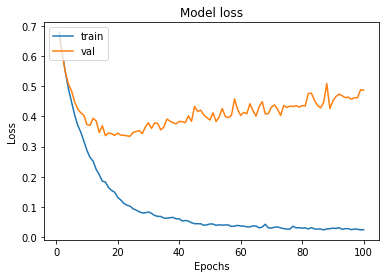

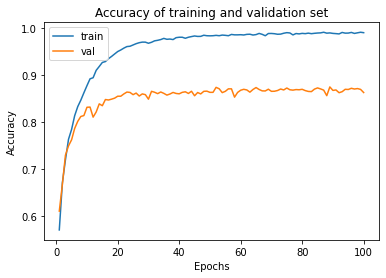

In [ ]:
#plot train/validation loss and train/validation accuracy 
history_dict = history.history
loss_values=history_dict['loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs,history_dict['loss'])
plt.plot(epochs, history_dict['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

accuracy_values = history_dict['accuracy']
val_accuracy= history_dict['val_accuracy']
plt.plot(epochs, accuracy_values)
plt.plot(epochs, val_accuracy)
plt.title('Accuracy of training and validation set') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# 2. IMPACT OF SENSOR COMBINATION

In [ ]:
#================================Seperate acceleration locations================================
def seperate_Acc_signals(type_signal,ALL_data):
  if type_signal=='pelvis':
    ALL_data=ALL_data[:,:,0:3]
  elif type_signal=='head':
    ALL_data=ALL_data[:,:,3:6]
  elif type_signal=='right_shoulder':
    ALL_data=ALL_data[:,:,6:9]
  elif type_signal=='right_hand':
    ALL_data=ALL_data[:,:,15:18]
  elif type_signal=='left_hand':
    ALL_data=ALL_data[:,:,27:30]
  elif type_signal=='left_shoulder':
    ALL_data=ALL_data[:,:,30:33]
  elif type_signal=='right_lower_leg':
    ALL_data=ALL_data[:,:,33:36]
  elif type_signal=='right_foot':
    ALL_data=ALL_data[:,:,36:39]
  elif type_signal=='left_lower_leg':
    ALL_data=ALL_data[:,:,42:45]
  elif type_signal=='left_foot':
    ALL_data=ALL_data[:,:,45:48]
  return ALL_data

In [ ]:
#================================Seperate gyro locations================================
def seperate_Gyro_signals(type_signal,ALL_data): #seven sensors
  if type_signal=='pelvis':
    ALL_data=ALL_data[:,:,0:3]
  elif type_signal=='right_shoulder':
    ALL_data=ALL_data[:,:,3:6]
  elif type_signal=='right_hand':
    ALL_data=ALL_data[:,:,9:12]
  elif type_signal=='left_shoulder':
    ALL_data=ALL_data[:,:,12:15]
  elif type_signal=='left_hand':
    ALL_data=ALL_data[:,:,18:21]
  elif type_signal=='right_lower_leg':
    ALL_data=ALL_data[:,:,21:24]
  elif type_signal=='right_foot':
    ALL_data=ALL_data[:,:,24:27]
  elif type_signal=='left_lower_leg':
    ALL_data=ALL_data[:,:,30:33]
  elif type_signal=='left_foot':
    ALL_data=ALL_data[:,:,33:36]
  return ALL_data

## 2.1 FULL BODY

### acceleration

In [ ]:
#seperate train,validation and test set 
X_train,y_train,X_test,y_test,X_validation, y_validation=final_prep(ALL_data_acc, ALL_Surfaces.to_numpy(), ALL_Participants_numb.to_numpy(),False)

Tensor train shape: (20368, 101, 48)
Tensor validation shape: (5092, 101, 48)
Tensor test shape: (2829, 101, 48)


In [ ]:
model=CNN_test(X_train.shape[1:],2) 
history= model.fit(X_train,y_train, epochs=100, batch_size=200,validation_data=(X_validation, y_validation))

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


102/102 [==============================] - 15s 136ms/step - loss: 1.3094 - accuracy: 0.5109 - val_loss: 0.6928 - val_accuracy: 0.5269
Epoch 2/100
102/102 [==============================] - 12s 116ms/step - loss: 0.6927 - accuracy: 0.5256 - val_loss: 0.6918 - val_accuracy: 0.5338
Epoch 3/100
102/102 [==============================] - 12s 114ms/step - loss: 0.6885 - accuracy: 0.5441 - val_loss: 0.6814 - val_accuracy: 0.5530
Epoch 4/100
102/102 [==============================] - 12s 115ms/step - loss: 0.6704 - accuracy: 0.5726 - val_loss: 0.6525 - val_accuracy: 0.6039
Epoch 5/100
102/102 [==============================] - 12s 116ms/step - loss: 0.6318 - accuracy: 0.6209 - val_loss: 0.6038 - val_accuracy: 0.6518
Epoch 6/100
102/102 [==============================] - 12s 115ms/step - loss: 0.5726 - accuracy: 0.6836 - val_loss: 0.5331 - val_accuracy: 0.7327
Epoch 7/100
102/102 [==============================] - 12s 117ms/step - loss: 0.5067 - accuracy: 0.7403 - val_loss: 0.4882 - val_accurac

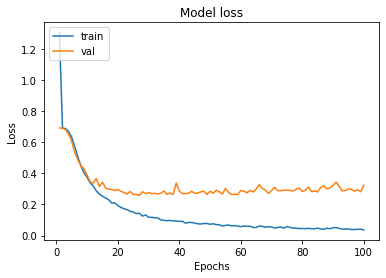

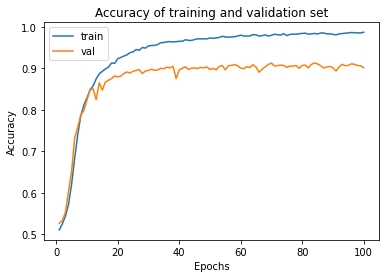

In [ ]:
#plot train/validation loss and train/validation accuracy 
history_dict = history.history
loss_values=history_dict['loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs,history_dict['loss'])
plt.plot(epochs, history_dict['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

accuracy_values = history_dict['accuracy']
val_accuracy= history_dict['val_accuracy']
plt.plot(epochs, accuracy_values)
plt.plot(epochs, val_accuracy)
plt.title('Accuracy of training and validation set') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### angular velocity

In [ ]:
#seperate train,validation and test set
X_train,y_train,X_test,y_test,X_validation, y_validation=final_prep(ALL_data_gyro, ALL_Surfaces.to_numpy(), ALL_Participants_numb.to_numpy(),False)

Tensor train shape: (20368, 101, 36)
Tensor validation shape: (5092, 101, 36)
Tensor test shape: (2829, 101, 36)


In [ ]:
model=CNN_test(X_train.shape[1:],2) 
history= model.fit(X_train,y_train, epochs=100, batch_size=200,validation_data=(X_validation, y_validation))

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


102/102 [==============================] - 17s 151ms/step - loss: 0.8041 - accuracy: 0.5213 - val_loss: 0.6880 - val_accuracy: 0.5471
Epoch 2/100
102/102 [==============================] - 11s 105ms/step - loss: 0.6756 - accuracy: 0.5726 - val_loss: 0.6588 - val_accuracy: 0.6176
Epoch 3/100
102/102 [==============================] - 11s 105ms/step - loss: 0.6292 - accuracy: 0.6442 - val_loss: 0.6116 - val_accuracy: 0.6775
Epoch 4/100
102/102 [==============================] - 11s 105ms/step - loss: 0.5664 - accuracy: 0.7041 - val_loss: 0.5577 - val_accuracy: 0.7215
Epoch 5/100
102/102 [==============================] - 11s 106ms/step - loss: 0.5143 - accuracy: 0.7433 - val_loss: 0.5346 - val_accuracy: 0.7341
Epoch 6/100
102/102 [==============================] - 11s 106ms/step - loss: 0.4684 - accuracy: 0.7764 - val_loss: 0.4790 - val_accuracy: 0.7732
Epoch 7/100
102/102 [==============================] - 11s 107ms/step - loss: 0.4293 - accuracy: 0.7961 - val_loss: 0.4540 - val_accurac

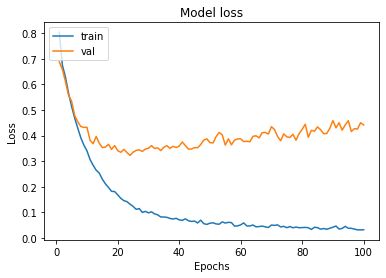

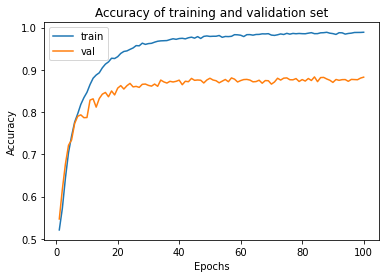

In [ ]:
#plot train/validation loss and train/validation accuracy 
history_dict = history.history
loss_values=history_dict['loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs,history_dict['loss'])
plt.plot(epochs, history_dict['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

accuracy_values = history_dict['accuracy']
val_accuracy= history_dict['val_accuracy']
plt.plot(epochs, accuracy_values)
plt.plot(epochs, val_accuracy)
plt.title('Accuracy of training and validation set') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Quick test Upper body with acceleration

In [ ]:
ALL_data_acc_head=seperate_Acc_signals('head',ALL_data_acc)
ALL_data_acc_RS=seperate_Acc_signals('right_shoulder',ALL_data_acc)
ALL_data_acc_LS=seperate_Acc_signals('left_shoulder',ALL_data_acc)
ALL_data_acc_RH=seperate_Acc_signals('right_hand',ALL_data_acc)
ALL_data_acc_LH=seperate_Acc_signals('left_hand',ALL_data_acc)

ALL_data_upperBody= tf.concat([ALL_data_acc_head,ALL_data_acc_RS,ALL_data_acc_LS,ALL_data_acc_RH,ALL_data_acc_LH], axis=2)

In [ ]:
#seperate train,validation and test set 
X_train,y_train,X_test,y_test,X_validation, y_validation=final_prep(ALL_data_upperBody.numpy(), ALL_Surfaces.to_numpy(), ALL_Participants_numb.to_numpy(),False)

Tensor train shape: (20368, 101, 15)
Tensor validation shape: (5092, 101, 15)
Tensor test shape: (2829, 101, 15)


In [ ]:
model=CNN_test(X_train.shape[1:],2) 
history= model.fit(X_train,y_train, epochs=100, batch_size=200,validation_data=(X_validation, y_validation))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
102/102 [==============================] - 15s 129ms/step - loss: 1.0835 - accuracy: 0.5107 - val_loss: 0.6929 - val_accuracy: 0.5281
Epoch 2/100
102/102 [==============================] - 10s 102ms/step - loss: 0.6912 - accuracy: 0.5367 - val_loss: 0.6905 - val_accuracy: 0.5452
Epoch 3/100
102/102 [==============================] - 10s 102ms/step - loss: 0.6850 - accuracy: 0.5509 - val_loss: 0.6818 - val_accuracy: 0.5687
Epoch 4/100
102/102 [==============================] - 10s 102ms/step - loss: 0.6752 - accuracy: 0.5708 - val_loss: 0.6731 - val_accuracy: 0.5748
Epoch 5/100
102/102 [==============================] - 10s 102ms/step - loss: 0.6589 - accuracy: 0.5962 - val_loss: 0.6565 - val_accuracy: 0.6029
Epoch 6/100
102/102 [==============================] - 10s 102ms/step - loss: 0.6386 - accuracy: 0.6290 - val_loss: 0.6473 - val_accuracy: 0.6204
Epoch 7/100
102/102 [==============================] - 10s 102ms/step - loss: 0.6162 - accuracy: 0.6564 - val_loss: 0.6296 -

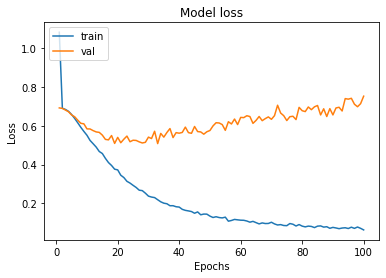

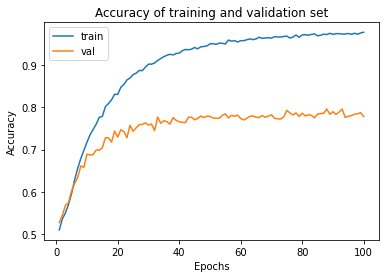

In [ ]:
#plot train/validation loss and train/validation accuracy 
history_dict = history.history
loss_values=history_dict['loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs,history_dict['loss'])
plt.plot(epochs, history_dict['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

accuracy_values = history_dict['accuracy']
val_accuracy= history_dict['val_accuracy']
plt.plot(epochs, accuracy_values)
plt.plot(epochs, val_accuracy)
plt.title('Accuracy of training and validation set') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## 2.2 LOWER BODY

### aceleration

In [ ]:
ALL_data_acc_LF=seperate_Acc_signals('left_foot',ALL_data_acc)
ALL_data_acc_LLL=seperate_Acc_signals('left_lower_leg',ALL_data_acc)
ALL_data_acc_RF=seperate_Acc_signals('right_foot',ALL_data_acc)
ALL_data_acc_RLL=seperate_Acc_signals('right_lower_leg',ALL_data_acc)
ALL_data_acc_pelvis=seperate_Acc_signals('pelvis',ALL_data_acc)

ALL_data_LowerBody= tf.concat([ALL_data_acc_LF,ALL_data_acc_RF,ALL_data_acc_LLL,ALL_data_acc_RLL,ALL_data_acc_pelvis], axis=2)

In [ ]:
#seperate train,validation and test set 
X_train,y_train,X_test,y_test,X_validation, y_validation=final_prep(ALL_data_LowerBody.numpy(), ALL_Surfaces.to_numpy(), ALL_Participants_numb.to_numpy(),False)

Tensor train shape: (20368, 101, 15)
Tensor validation shape: (5092, 101, 15)
Tensor test shape: (2829, 101, 15)


In [ ]:
model=CNN_test(X_train.shape[1:],2) 
history= model.fit(X_train,y_train, epochs=100, batch_size=200,validation_data=(X_validation, y_validation))

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


102/102 [==============================] - 11s 98ms/step - loss: 1.0582 - accuracy: 0.5320 - val_loss: 0.6818 - val_accuracy: 0.5733
Epoch 2/100
102/102 [==============================] - 11s 112ms/step - loss: 0.6690 - accuracy: 0.5798 - val_loss: 0.6471 - val_accuracy: 0.6196
Epoch 3/100
102/102 [==============================] - 10s 96ms/step - loss: 0.6185 - accuracy: 0.6535 - val_loss: 0.5752 - val_accuracy: 0.7145
Epoch 4/100
102/102 [==============================] - 10s 96ms/step - loss: 0.5544 - accuracy: 0.7151 - val_loss: 0.5156 - val_accuracy: 0.7669
Epoch 5/100
102/102 [==============================] - 10s 96ms/step - loss: 0.4886 - accuracy: 0.7628 - val_loss: 0.4573 - val_accuracy: 0.7979
Epoch 6/100
102/102 [==============================] - 10s 97ms/step - loss: 0.4507 - accuracy: 0.7853 - val_loss: 0.4382 - val_accuracy: 0.7932
Epoch 7/100
102/102 [==============================] - 10s 96ms/step - loss: 0.4010 - accuracy: 0.8129 - val_loss: 0.3894 - val_accuracy: 0.8

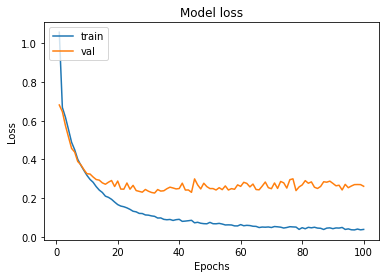

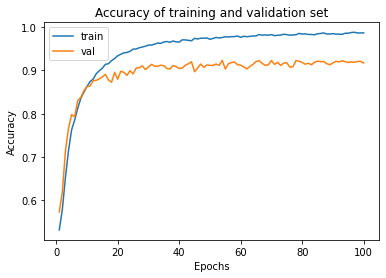

In [ ]:
#plot train/validation loss and train/validation accuracy 
history_dict = history.history
loss_values=history_dict['loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs,history_dict['loss'])
plt.plot(epochs, history_dict['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

accuracy_values = history_dict['accuracy']
val_accuracy= history_dict['val_accuracy']
plt.plot(epochs, accuracy_values)
plt.plot(epochs, val_accuracy)
plt.title('Accuracy of training and validation set') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### angular velocity

In [ ]:
pelvis_gyro=seperate_Gyro_signals('pelvis',ALL_data_gyro)
RLL_gyro=seperate_Gyro_signals('right_lower_leg',ALL_data_gyro)
LLL_gyro=seperate_Gyro_signals('left_lower_leg',ALL_data_gyro)
LF_gyro=seperate_Gyro_signals('right_foot',ALL_data_gyro)
RF_gyro=seperate_Gyro_signals('right_lower_leg',ALL_data_gyro)

Lower_body_gyro= tf.concat([pelvis_gyro,RLL_gyro,LLL_gyro,LF_gyro,RF_gyro], axis=2)

In [ ]:
X_train,y_train,X_test,y_test,X_validation, y_validation=final_prep(Lower_body_gyro.numpy(), ALL_Surfaces.to_numpy(), ALL_Participants_numb.to_numpy(),False)

Tensor train shape: (20368, 101, 15)
Tensor validation shape: (5092, 101, 15)
Tensor test shape: (2829, 101, 15)


In [ ]:
model=CNN_test(X_train.shape[1:],2) 
history= model.fit(X_train,y_train, epochs=50, batch_size=200,validation_data=(X_validation, y_validation))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
102/102 [==============================] - 20s 187ms/step - loss: 0.7656 - accuracy: 0.5252 - val_loss: 0.6870 - val_accuracy: 0.5479
Epoch 2/50
102/102 [==============================] - 10s 97ms/step - loss: 0.6795 - accuracy: 0.5649 - val_loss: 0.6764 - val_accuracy: 0.5817
Epoch 3/50
102/102 [==============================] - 9s 91ms/step - loss: 0.6416 - accuracy: 0.6332 - val_loss: 0.6327 - val_accuracy: 0.6520
Epoch 4/50
102/102 [==============================] - 9s 92ms/step - loss: 0.5958 - accuracy: 0.6793 - val_loss: 0.5919 - val_accuracy: 0.6927
Epoch 5/50
102/102 [==============================] - 9s 92ms/step - loss: 0.5497 - accuracy: 0.7135 - val_loss: 0.5477 - val_accuracy: 0.7172
Epoch 6/50
102/102 [==============================] - 9s 92ms/step - loss: 0.5113 - accuracy: 0.7386 - val_loss: 0.5313 - val_accuracy: 0.7319
Epoch 7/50
102/102 [==============================] - 9s 92ms/step - loss: 0.4807 - accuracy: 0.7624 - val_loss: 0.5020 - val_accuracy: 0.7

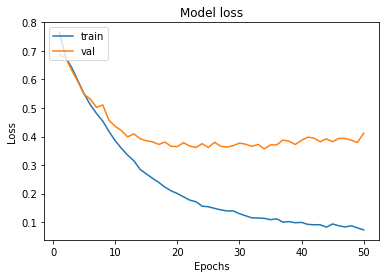

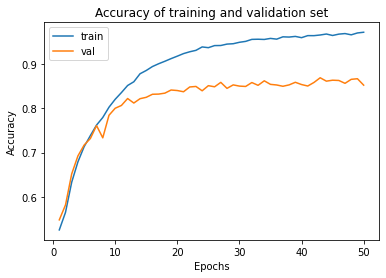

In [ ]:
#plot train/validation loss and train/validation accuracy 
history_dict = history.history
loss_values=history_dict['loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs,history_dict['loss'])
plt.plot(epochs, history_dict['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

accuracy_values = history_dict['accuracy']
val_accuracy= history_dict['val_accuracy']
plt.plot(epochs, accuracy_values)
plt.plot(epochs, val_accuracy)
plt.title('Accuracy of training and validation set') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## 2.3 PELVIS

### acceleration

In [ ]:
ALL_data_acc_pelvis=seperate_Acc_signals('pelvis',ALL_data_acc)

In [ ]:
#seperate train,validation and test set 
X_train,y_train,X_test,y_test,X_validation, y_validation=final_prep(ALL_data_acc_pelvis, ALL_Surfaces.to_numpy(), ALL_Participants_numb.to_numpy(),False)

Tensor train shape: (20368, 101, 3)
Tensor validation shape: (5092, 101, 3)
Tensor test shape: (2829, 101, 3)


In [ ]:
model=CNN_test(X_train.shape[1:],2) 
history= model.fit(X_train,y_train, epochs=100, batch_size=200,validation_data=(X_validation, y_validation))

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


102/102 [==============================] - 10s 88ms/step - loss: 0.7864 - accuracy: 0.5559 - val_loss: 0.6727 - val_accuracy: 0.5835
Epoch 2/100
102/102 [==============================] - 9s 86ms/step - loss: 0.6682 - accuracy: 0.5882 - val_loss: 0.6645 - val_accuracy: 0.6033
Epoch 3/100
102/102 [==============================] - 7s 69ms/step - loss: 0.6483 - accuracy: 0.6195 - val_loss: 0.6494 - val_accuracy: 0.6206
Epoch 4/100
102/102 [==============================] - 7s 69ms/step - loss: 0.6288 - accuracy: 0.6435 - val_loss: 0.6363 - val_accuracy: 0.6436
Epoch 5/100
102/102 [==============================] - 7s 68ms/step - loss: 0.6080 - accuracy: 0.6649 - val_loss: 0.6220 - val_accuracy: 0.6544
Epoch 6/100
102/102 [==============================] - 7s 69ms/step - loss: 0.5869 - accuracy: 0.6873 - val_loss: 0.6137 - val_accuracy: 0.6542
Epoch 7/100
102/102 [==============================] - 7s 68ms/step - loss: 0.5635 - accuracy: 0.7067 - val_loss: 0.5939 - val_accuracy: 0.6775
Epo

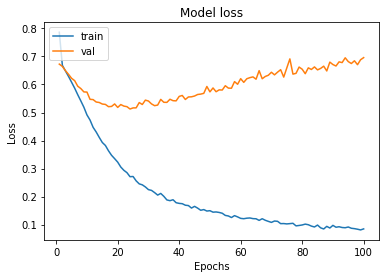

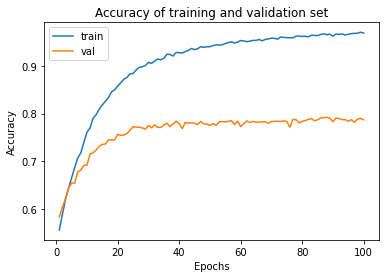

In [ ]:
#plot train/validation loss and train/validation accuracy 
history_dict = history.history
loss_values=history_dict['loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs,history_dict['loss'])
plt.plot(epochs, history_dict['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

accuracy_values = history_dict['accuracy']
val_accuracy= history_dict['val_accuracy']
plt.plot(epochs, accuracy_values)
plt.plot(epochs, val_accuracy)
plt.title('Accuracy of training and validation set') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### angular velocity

In [ ]:
pelvis_gyro=seperate_Gyro_signals('pelvis',ALL_data_gyro)

In [ ]:
X_train,y_train,X_test,y_test,X_validation, y_validation=final_prep(pelvis_gyro, ALL_Surfaces.to_numpy(), ALL_Participants_numb.to_numpy(),False)

Tensor train shape: (20368, 101, 3)
Tensor validation shape: (5092, 101, 3)
Tensor test shape: (2829, 101, 3)


In [ ]:
model=CNN_test(X_train.shape[1:],2) 
history= model.fit(X_train,y_train, epochs=100, batch_size=200,validation_data=(X_validation, y_validation))

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


102/102 [==============================] - 8s 74ms/step - loss: 0.6813 - accuracy: 0.5597 - val_loss: 0.6698 - val_accuracy: 0.5927
Epoch 2/100
102/102 [==============================] - 7s 71ms/step - loss: 0.6494 - accuracy: 0.6150 - val_loss: 0.6444 - val_accuracy: 0.6194
Epoch 3/100
102/102 [==============================] - 7s 72ms/step - loss: 0.6101 - accuracy: 0.6584 - val_loss: 0.6208 - val_accuracy: 0.6471
Epoch 4/100
102/102 [==============================] - 7s 71ms/step - loss: 0.5712 - accuracy: 0.6980 - val_loss: 0.5880 - val_accuracy: 0.6842
Epoch 5/100
102/102 [==============================] - 7s 73ms/step - loss: 0.5268 - accuracy: 0.7341 - val_loss: 0.5741 - val_accuracy: 0.6940
Epoch 6/100
102/102 [==============================] - 7s 72ms/step - loss: 0.4903 - accuracy: 0.7589 - val_loss: 0.5590 - val_accuracy: 0.7101
Epoch 7/100
102/102 [==============================] - 8s 74ms/step - loss: 0.4514 - accuracy: 0.7851 - val_loss: 0.5402 - val_accuracy: 0.7233
Epoc

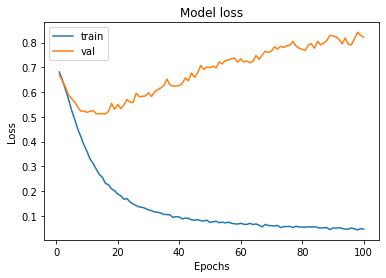

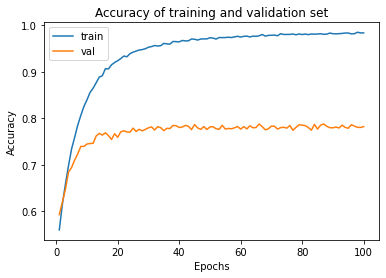

In [ ]:
#plot train/validation loss and train/validation accuracy 
history_dict = history.history
loss_values=history_dict['loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs,history_dict['loss'])
plt.plot(epochs, history_dict['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

accuracy_values = history_dict['accuracy']
val_accuracy= history_dict['val_accuracy']
plt.plot(epochs, accuracy_values)
plt.plot(epochs, val_accuracy)
plt.title('Accuracy of training and validation set') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## 2.4 FEET

### acceleration

In [ ]:
ALL_data_acc_LF=seperate_Acc_signals('left_foot',ALL_data_acc)
ALL_data_acc_RF=seperate_Acc_signals('right_foot',ALL_data_acc)

Foot= tf.concat([ALL_data_acc_LF,ALL_data_acc_RF], axis=2)

In [ ]:
#seperate train,validation and test set 
X_train,y_train,X_test,y_test,X_validation, y_validation=final_prep(Foot.numpy(), ALL_Surfaces.to_numpy(), ALL_Participants_numb.to_numpy(),False)

Tensor train shape: (20368, 101, 6)
Tensor validation shape: (5092, 101, 6)
Tensor test shape: (2829, 101, 6)


In [ ]:
model=CNN_test(X_train.shape[1:],2) 
history= model.fit(X_train,y_train, epochs=100, batch_size=200,validation_data=(X_validation, y_validation))

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


102/102 [==============================] - 15s 139ms/step - loss: 1.1435 - accuracy: 0.5199 - val_loss: 0.6842 - val_accuracy: 0.5568
Epoch 2/100
102/102 [==============================] - 10s 99ms/step - loss: 0.6759 - accuracy: 0.5607 - val_loss: 0.6567 - val_accuracy: 0.5990
Epoch 3/100
102/102 [==============================] - 7s 72ms/step - loss: 0.6353 - accuracy: 0.6235 - val_loss: 0.5961 - val_accuracy: 0.6854
Epoch 4/100
102/102 [==============================] - 7s 72ms/step - loss: 0.5786 - accuracy: 0.6858 - val_loss: 0.5427 - val_accuracy: 0.7176
Epoch 5/100
102/102 [==============================] - 7s 72ms/step - loss: 0.5252 - accuracy: 0.7325 - val_loss: 0.4836 - val_accuracy: 0.7714
Epoch 6/100
102/102 [==============================] - 7s 72ms/step - loss: 0.4810 - accuracy: 0.7590 - val_loss: 0.4439 - val_accuracy: 0.7956
Epoch 7/100
102/102 [==============================] - 7s 72ms/step - loss: 0.4445 - accuracy: 0.7897 - val_loss: 0.4252 - val_accuracy: 0.8056
E

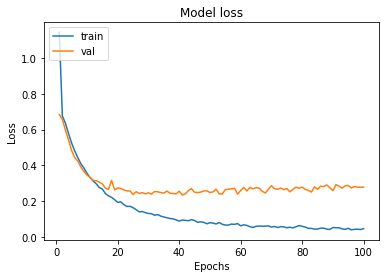

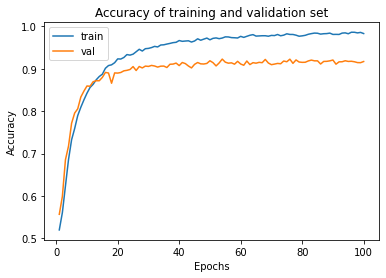

In [ ]:
#plot train/validation loss and train/validation accuracy 
history_dict = history.history
loss_values=history_dict['loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs,history_dict['loss'])
plt.plot(epochs, history_dict['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

accuracy_values = history_dict['accuracy']
val_accuracy= history_dict['val_accuracy']
plt.plot(epochs, accuracy_values)
plt.plot(epochs, val_accuracy)
plt.title('Accuracy of training and validation set') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### angular velocity

In [ ]:
Foot_gyro= tf.concat([LF_gyro,RF_gyro], axis=2)

In [ ]:
X_train,y_train,X_test,y_test,X_validation, y_validation=final_prep(Foot_gyro.numpy(), ALL_Surfaces.to_numpy(), ALL_Participants_numb.to_numpy(),False)

Tensor train shape: (20368, 101, 6)
Tensor validation shape: (5092, 101, 6)
Tensor test shape: (2829, 101, 6)


In [ ]:
model=CNN_test(X_train.shape[1:],2) 
history= model.fit(X_train,y_train, epochs=100, batch_size=200,validation_data=(X_validation, y_validation))

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


102/102 [==============================] - 9s 77ms/step - loss: 0.8109 - accuracy: 0.5248 - val_loss: 0.6862 - val_accuracy: 0.5709
Epoch 2/100
102/102 [==============================] - 8s 74ms/step - loss: 0.6748 - accuracy: 0.5731 - val_loss: 0.6650 - val_accuracy: 0.6125
Epoch 3/100
102/102 [==============================] - 8s 77ms/step - loss: 0.6438 - accuracy: 0.6261 - val_loss: 0.6320 - val_accuracy: 0.6534
Epoch 4/100
102/102 [==============================] - 8s 74ms/step - loss: 0.6048 - accuracy: 0.6713 - val_loss: 0.5999 - val_accuracy: 0.6974
Epoch 5/100
102/102 [==============================] - 8s 76ms/step - loss: 0.5677 - accuracy: 0.7016 - val_loss: 0.5662 - val_accuracy: 0.7198
Epoch 6/100
102/102 [==============================] - 8s 75ms/step - loss: 0.5300 - accuracy: 0.7336 - val_loss: 0.5391 - val_accuracy: 0.7382
Epoch 7/100
102/102 [==============================] - 8s 75ms/step - loss: 0.5003 - accuracy: 0.7518 - val_loss: 0.5191 - val_accuracy: 0.7608
Epoc

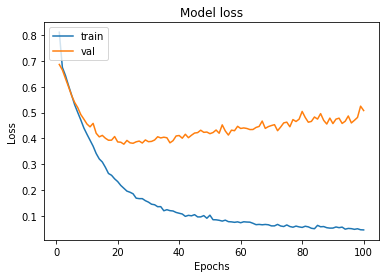

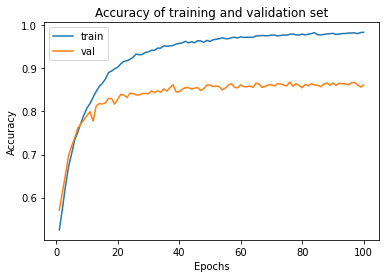

In [ ]:
#plot train/validation loss and train/validation accuracy 
history_dict = history.history
loss_values=history_dict['loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs,history_dict['loss'])
plt.plot(epochs, history_dict['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

accuracy_values = history_dict['accuracy']
val_accuracy= history_dict['val_accuracy']
plt.plot(epochs, accuracy_values)
plt.plot(epochs, val_accuracy)
plt.title('Accuracy of training and validation set') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# 3. KERAS TUNER- FINAL MODEL

In [ ]:
pip install keras-tuner

In [ ]:
import kerastuner as kt
import keras

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  """Entry point for launching an IPython kernel.


variable already tested: RMSprop, 3 layers, no regularization, and batch size=200

In [ ]:
def build_model(hp):
  input_layer = keras.layers.Input(X_train.shape[1:])

  conv1 = keras.layers.Conv1D(
          filters = hp.Int('filters1', 32, 256, step=32),
          kernel_size = hp.Int('kernel_size1', 3, 5),
          padding = 'same')(input_layer)
  conv1 = keras.layers.BatchNormalization()(conv1)
  conv1 = keras.layers.ReLU()(conv1)
  conv1 = keras.layers.Dropout(
          rate = hp.Float('dropout1', 0, 0.5, step=0.1))(conv1)

  conv2 = keras.layers.Conv1D(          
          filters = hp.Int('filters2',32, 256, step=32),
          kernel_size = hp.Int('kernel_size2', 3, 5),
          padding = 'same')(conv1)
  conv2 = keras.layers.BatchNormalization()(conv2)
  conv2 = keras.layers.ReLU()(conv2)
  conv2 = keras.layers.Dropout(
          rate = hp.Float('dropout2', 0, 0.5,step=0.1))(conv2)

  conv3 = keras.layers.Conv1D(
          filters = hp.Int('filters3', 32, 256, step=32),
          kernel_size = hp.Int('kernel_size3', 3, 5),
          padding = 'same')(conv2)
  conv3 = keras.layers.BatchNormalization()(conv3)
  conv3 = keras.layers.ReLU()(conv3)
  conv3 = keras.layers.Dropout(
          rate = hp.Float('dropout3', 0, 0.5, step=0.1))(conv3)

  gap = keras.layers.GlobalAveragePooling1D()(conv3)

  output_layer = keras.layers.Dense(2, activation="softmax")(gap)

  model = keras.Model(input_layer, output_layer)

  model.compile(optimizer=Adam(
                hp.Float(
                    'learning_rate',
                    min_value=1e-4,
                    max_value=1e-2,
                    sampling='LOG',
                    default=1e-3
                )
            ),    
            loss='binary_crossentropy',  metrics=['accuracy'])

  return model

callbacks = [
    # keras.callbacks.ReduceLROnPlateau(
    #     monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001),
    keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=20, verbose=1)]

In [ ]:
ALL_data_acc_LF=seperate_Acc_signals('left_foot',ALL_data_acc)
ALL_data_acc_RF=seperate_Acc_signals('right_foot',ALL_data_acc)

Foot= tf.concat([ALL_data_acc_LF,ALL_data_acc_RF], axis=2)

In [ ]:
X_train,y_train,X_test,y_test,X_validation, y_validation=final_prep(Foot.numpy(), ALL_Surfaces.to_numpy(), ALL_Participants_numb.to_numpy(),False)

Tensor train shape: (20368, 101, 6)
Tensor validation shape: (5092, 101, 6)
Tensor test shape: (2829, 101, 6)


In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=100,
    overwrite=True,
    directory="my_dir",
    project_name="tune_hypermodel_Foot_acc",
)

tuner.search_space_summary()

Search space summary
Default search space size: 10
filters1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
kernel_size1 (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 5, 'step': 1, 'sampling': None}
dropout1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
filters2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
kernel_size2 (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 5, 'step': 1, 'sampling': None}
dropout2 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
filters3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
kernel_size3 (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 5, 'step': 1, 'sampling': None}
dropout3 (Float

In [ ]:
#tune model
tuner.search(X_train, 
             y_train, 
             epochs=100,
             batch_size=200,
             validation_data=(X_validation, y_validation),
             callbacks=callbacks)

Trial 10 Complete [01h 29m 24s]
val_accuracy: 0.958562433719635

Best val_accuracy So Far: 0.9593480229377747
Total elapsed time: 14h 47m 44s

Search: Running Trial #11

Value             |Best Value So Far |Hyperparameter
32                |224               |filters1
3                 |3                 |kernel_size1
0.2               |0.3               |dropout1
96                |128               |filters2
4                 |3                 |kernel_size2
0.3               |0.1               |dropout2
224               |224               |filters3
5                 |4                 |kernel_size3
0.1               |0.2               |dropout3
0.0032415         |0.003796          |learning_rate

Epoch 1/100
102/102 [==============================] - 59s 562ms/step - loss: 0.6370 - accuracy: 0.6347 - val_loss: 0.7372 - val_accuracy: 0.5640
Epoch 2/100
102/102 [==============================] - 57s 562ms/step - loss: 0.5694 - accuracy: 0.7029 - val_loss: 1.2056 - val_accuracy: 0.48

# 4. SPLITTING PROTOCOLS

foot sensors

In [ ]:
import keras

def final_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=224, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)
    conv1 = keras.layers.Dropout(0.3)(conv1)

    conv2 = keras.layers.Conv1D(filters=128, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)
    conv2 = keras.layers.Dropout(0.1)(conv2)

    conv3 = keras.layers.Conv1D(filters=224, kernel_size=4, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)
    conv3 = keras.layers.Dropout(0.2)(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(2, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


## acceleration

subject-wise

In [ ]:
#seperate train,validation and test set 
X_train,y_train,X_test,y_test,X_validation, y_validation=final_prep(Foot.numpy(), ALL_Surfaces.to_numpy(), ALL_Participants_numb.to_numpy(),True)
#call model
model = final_model(X_train.shape[1:])



Tensor train shape: (20464, 101, 6)
Tensor validation shape: (5076, 101, 6)
Tensor test shape: (2749, 101, 6)


In [ ]:
#calling model
epochs = 500
batch_size = 200

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "model", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer=Adam(lr=0.0075),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(X_validation, y_validation),
    verbose=1,
)
score = model.evaluate(X_validation, y_validation, verbose=0) 
print(f'Score for: {model.metrics_names[0]} of {score[0]}; {model.metrics_names[1]} of {score[1]*100}%')

Epoch 1/500


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


103/103 [==============================] - 90s 862ms/step - loss: 0.6451 - accuracy: 0.6226 - val_loss: 1.4627 - val_accuracy: 0.5311 - lr: 0.0075
Epoch 2/500
103/103 [==============================] - 85s 824ms/step - loss: 0.5735 - accuracy: 0.7012 - val_loss: 0.7393 - val_accuracy: 0.6028 - lr: 0.0075
Epoch 3/500
103/103 [==============================] - 83s 806ms/step - loss: 0.5132 - accuracy: 0.7504 - val_loss: 0.8316 - val_accuracy: 0.6084 - lr: 0.0075
Epoch 4/500
103/103 [==============================] - 87s 843ms/step - loss: 0.4512 - accuracy: 0.7899 - val_loss: 0.5980 - val_accuracy: 0.7175 - lr: 0.0075
Epoch 5/500
103/103 [==============================] - 86s 834ms/step - loss: 0.4081 - accuracy: 0.8148 - val_loss: 0.4961 - val_accuracy: 0.7658 - lr: 0.0075
Epoch 6/500
103/103 [==============================] - 82s 798ms/step - loss: 0.3703 - accuracy: 0.8351 - val_loss: 0.6893 - val_accuracy: 0.6759 - lr: 0.0075
Epoch 7/500
103/103 [==============================] - 84s

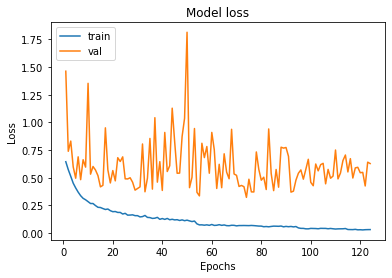

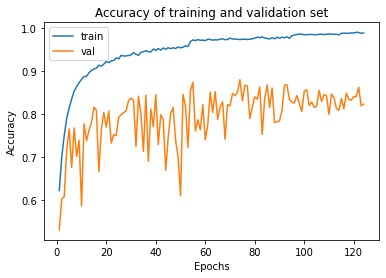

In [ ]:
#plot train/validation loss and train/validation accuracy 
history_dict = history.history
loss_values=history_dict['loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs,history_dict['loss'])
plt.plot(epochs, history_dict['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

accuracy_values = history_dict['accuracy']
val_accuracy= history_dict['val_accuracy']
plt.plot(epochs, accuracy_values)
plt.plot(epochs, val_accuracy)
plt.title('Accuracy of training and validation set') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

not subject wise

In [ ]:
#seperate train,validation and test set 
X_train,y_train,X_test,y_test,X_validation, y_validation=final_prep(Foot.numpy(), ALL_Surfaces.to_numpy(), ALL_Participants_numb.to_numpy(),False)
#call model
model = final_model(X_train.shape[1:])

Tensor train shape: (20368, 101, 6)
Tensor validation shape: (5092, 101, 6)
Tensor test shape: (2829, 101, 6)


In [ ]:
#calling model
epochs = 500
batch_size = 200

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "model", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer=Adam(lr=0.0075),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(X_validation, y_validation),
    verbose=1,
)
score = model.evaluate(X_validation, y_validation, verbose=0) 
print(f'Score for: {model.metrics_names[0]} of {score[0]}; {model.metrics_names[1]} of {score[1]*100}%')

Epoch 1/500


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


102/102 [==============================] - 87s 836ms/step - loss: 0.6522 - accuracy: 0.6130 - val_loss: 0.7859 - val_accuracy: 0.6528 - lr: 0.0075
Epoch 2/500
102/102 [==============================] - 84s 822ms/step - loss: 0.5878 - accuracy: 0.6867 - val_loss: 1.0534 - val_accuracy: 0.5218 - lr: 0.0075
Epoch 3/500
102/102 [==============================] - 84s 825ms/step - loss: 0.5210 - accuracy: 0.7402 - val_loss: 0.5014 - val_accuracy: 0.7594 - lr: 0.0075
Epoch 4/500
102/102 [==============================] - 82s 804ms/step - loss: 0.4611 - accuracy: 0.7851 - val_loss: 0.5519 - val_accuracy: 0.7274 - lr: 0.0075
Epoch 5/500
102/102 [==============================] - 82s 805ms/step - loss: 0.4248 - accuracy: 0.8096 - val_loss: 0.5579 - val_accuracy: 0.7190 - lr: 0.0075
Epoch 6/500
102/102 [==============================] - 83s 819ms/step - loss: 0.3896 - accuracy: 0.8240 - val_loss: 0.8533 - val_accuracy: 0.6159 - lr: 0.0075
Epoch 7/500
102/102 [==============================] - 82s

## angular velocity

subject-wise

In [ ]:
X_train,y_train,X_test,y_test,X_validation, y_validation=final_prep(Foot_gyro.numpy(), ALL_Surfaces.to_numpy(), ALL_Participants_numb.to_numpy(),True)
model = final_model(X_train.shape[1:])

Tensor train shape: (20464, 101, 6)
Tensor validation shape: (5076, 101, 6)
Tensor test shape: (2749, 101, 6)


In [ ]:
#calling model
epochs = 500
batch_size = 200

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "model", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer=Adam(lr=0.0075),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(X_validation, y_validation),
    verbose=1,
)
score = model.evaluate(X_validation, y_validation, verbose=0) 
print(f'Score for: {model.metrics_names[0]} of {score[0]}; {model.metrics_names[1]} of {score[1]*100}%')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/500
103/103 [==============================] - 118s 1s/step - loss: 0.7054 - accuracy: 0.5202 - val_loss: 0.7122 - val_accuracy: 0.4968 - lr: 0.0075
Epoch 2/500
103/103 [==============================] - 109s 1s/step - loss: 0.6881 - accuracy: 0.5450 - val_loss: 0.6953 - val_accuracy: 0.5307 - lr: 0.0075
Epoch 3/500
103/103 [==============================] - 106s 1s/step - loss: 0.6738 - accuracy: 0.5802 - val_loss: 0.8280 - val_accuracy: 0.5081 - lr: 0.0075
Epoch 4/500
103/103 [==============================] - 108s 1s/step - loss: 0.6645 - accuracy: 0.5953 - val_loss: 0.7360 - val_accuracy: 0.5313 - lr: 0.0075
Epoch 5/500
103/103 [==============================] - 109s 1s/step - loss: 0.6467 - accuracy: 0.6235 - val_loss: 0.6875 - val_accuracy: 0.5818 - lr: 0.0075
Epoch 6/500
103/103 [==============================] - 107s 1s/step - loss: 0.6193 - accuracy: 0.6535 - val_loss: 0.7910 - val_accuracy: 0.5471 - lr: 0.0075
Epoch 7/500
103/103 [==============================] - 107

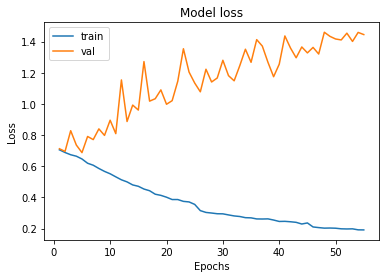

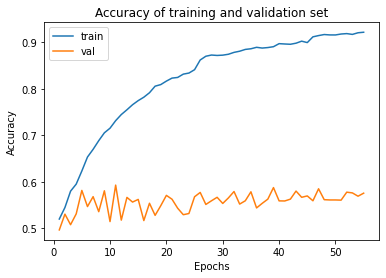

In [ ]:
#plot train/validation loss and train/validation accuracy 
history_dict = history.history
loss_values=history_dict['loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs,history_dict['loss'])
plt.plot(epochs, history_dict['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

accuracy_values = history_dict['accuracy']
val_accuracy= history_dict['val_accuracy']
plt.plot(epochs, accuracy_values)
plt.plot(epochs, val_accuracy)
plt.title('Accuracy of training and validation set') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

not subject wise

In [ ]:
X_train,y_train,X_test,y_test,X_validation, y_validation=final_prep(Foot_gyro.numpy(), ALL_Surfaces.to_numpy(), ALL_Participants_numb.to_numpy(),False)

Tensor train shape: (20368, 101, 6)
Tensor validation shape: (5092, 101, 6)
Tensor test shape: (2829, 101, 6)


In [ ]:
#calling model
epochs = 500
batch_size = 200

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "model", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer=Adam(lr=0.0075),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(X_validation, y_validation),
    verbose=1,
)
score = model.evaluate(X_validation, y_validation, verbose=0) 
print(f'Score for: {model.metrics_names[0]} of {score[0]}; {model.metrics_names[1]} of {score[1]*100}%')

Epoch 1/500


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


102/102 [==============================] - 90s 859ms/step - loss: 0.4123 - accuracy: 0.8224 - val_loss: 0.3154 - val_accuracy: 0.8651 - lr: 0.0075
Epoch 2/500
102/102 [==============================] - 86s 844ms/step - loss: 0.3696 - accuracy: 0.8354 - val_loss: 0.3348 - val_accuracy: 0.8564 - lr: 0.0075
Epoch 3/500
102/102 [==============================] - 87s 852ms/step - loss: 0.3389 - accuracy: 0.8519 - val_loss: 0.2949 - val_accuracy: 0.8784 - lr: 0.0075
Epoch 4/500
102/102 [==============================] - 86s 840ms/step - loss: 0.3230 - accuracy: 0.8596 - val_loss: 0.3201 - val_accuracy: 0.8629 - lr: 0.0075
Epoch 5/500
102/102 [==============================] - 84s 821ms/step - loss: 0.3311 - accuracy: 0.8522 - val_loss: 0.3565 - val_accuracy: 0.8478 - lr: 0.0075
Epoch 6/500
102/102 [==============================] - 85s 832ms/step - loss: 0.3083 - accuracy: 0.8661 - val_loss: 0.4521 - val_accuracy: 0.8011 - lr: 0.0075
Epoch 7/500
102/102 [==============================] - 83s

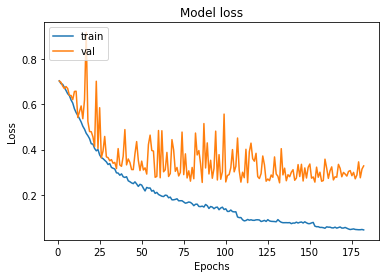

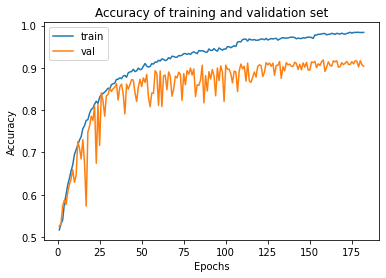

In [ ]:
#plot train/validation loss and train/validation accuracy 
history_dict = history.history
loss_values=history_dict['loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs,history_dict['loss'])
plt.plot(epochs, history_dict['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

accuracy_values = history_dict['accuracy']
val_accuracy= history_dict['val_accuracy']
plt.plot(epochs, accuracy_values)
plt.plot(epochs, val_accuracy)
plt.title('Accuracy of training and validation set') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# 5. FINAL MODEL

In [ ]:
import keras

def final_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=224, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)
    conv1 = keras.layers.Dropout(0.3)(conv1)

    conv2 = keras.layers.Conv1D(filters=128, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)
    conv2 = keras.layers.Dropout(0.1)(conv2)

    conv3 = keras.layers.Conv1D(filters=224, kernel_size=4, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)
    conv3 = keras.layers.Dropout(0.2)(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(2, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

## acceleration

In [ ]:
ALL_data_acc_LF=seperate_Acc_signals('left_foot',ALL_data_acc)
ALL_data_acc_RF=seperate_Acc_signals('right_foot',ALL_data_acc)

Foot= tf.concat([ALL_data_acc_LF,ALL_data_acc_RF], axis=2)

In [ ]:
X_train,y_train,X_test,y_test,X_validation, y_validation=final_prep(Foot.numpy(), ALL_Surfaces.to_numpy(), ALL_Participants_numb.to_numpy(),False)

Tensor train shape: (20368, 101, 6)
Tensor validation shape: (5092, 101, 6)
Tensor test shape: (2829, 101, 6)


Epoch 1/500


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


102/102 [==============================] - 102s 983ms/step - loss: 0.6448 - accuracy: 0.6194 - val_loss: 1.2202 - val_accuracy: 0.5740
Epoch 2/500
102/102 [==============================] - 96s 940ms/step - loss: 0.5693 - accuracy: 0.7019 - val_loss: 1.4802 - val_accuracy: 0.4853
Epoch 3/500
102/102 [==============================] - 99s 966ms/step - loss: 0.4962 - accuracy: 0.7584 - val_loss: 0.6206 - val_accuracy: 0.6764
Epoch 4/500
102/102 [==============================] - 97s 955ms/step - loss: 0.4462 - accuracy: 0.7946 - val_loss: 0.3894 - val_accuracy: 0.8354
Epoch 5/500
102/102 [==============================] - 95s 933ms/step - loss: 0.4063 - accuracy: 0.8166 - val_loss: 0.4004 - val_accuracy: 0.8174
Epoch 6/500
102/102 [==============================] - 95s 933ms/step - loss: 0.3686 - accuracy: 0.8389 - val_loss: 0.5248 - val_accuracy: 0.7516
Epoch 7/500
102/102 [==============================] - 100s 978ms/step - loss: 0.3501 - accuracy: 0.8459 - val_loss: 0.3046 - val_accur

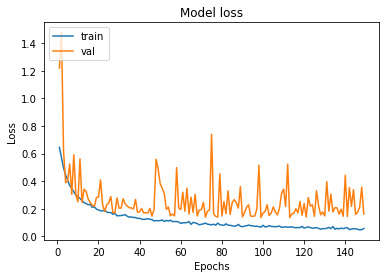

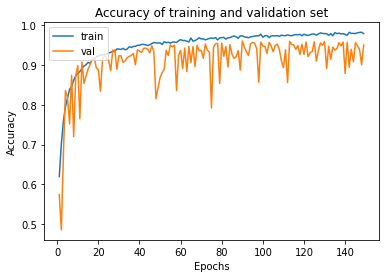

Score for: loss of 0.1616748869419098; accuracy of 95.0117826461792%
              precision    recall  f1-score   support

       grass     0.9265    0.9706    0.9481      1429
     asphalt     0.9685    0.9214    0.9444      1400

    accuracy                         0.9463      2829
   macro avg     0.9475    0.9460    0.9462      2829
weighted avg     0.9473    0.9463    0.9462      2829



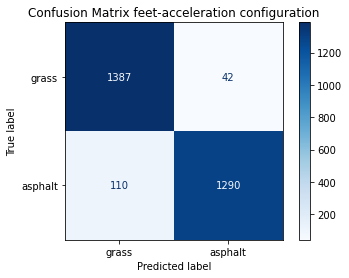

In [ ]:
model = final_model(X_train.shape[1:])

#calling model
epochs = 200
batch_size = 200

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "model", save_best_only=True, monitor="val_loss"
    ),
    # keras.callbacks.ReduceLROnPlateau(
    #     monitor="val_loss", factor=0.5, patience=20
    # ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer=Adam(lr=0.0075),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(X_validation, y_validation),
    verbose=1,
)


#plot
#plot train/validation loss and train/validation accuracy 
history_dict = history.history
loss_values=history_dict['loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs,history_dict['loss'])
plt.plot(epochs, history_dict['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

accuracy_values = history_dict['accuracy']
val_accuracy= history_dict['val_accuracy']
plt.plot(epochs, accuracy_values)
plt.plot(epochs, val_accuracy)
plt.title('Accuracy of training and validation set') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#validation score
score = model.evaluate(X_validation, y_validation, verbose=0) 
print(f'Score for: {model.metrics_names[0]} of {score[0]}; {model.metrics_names[1]} of {score[1]*100}%')

#recall, f1-score, precision 
labels = ['grass', 'asphalt']


y_test_arg=np.argmax(y_test,axis=1)
Y_pred = np.argmax(model.predict(X_test),axis=1)

from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

print(classification_report(y_test_arg, Y_pred, target_names=labels, digits=4))


#confusion matrix
confusion_matrix = confusion_matrix(y_test_arg, Y_pred)

cmd = ConfusionMatrixDisplay.from_predictions(y_test_arg,
                                              Y_pred,
                                              display_labels=labels,
                                              cmap=plt.cm.Blues)
cmd.ax_.set_title("Confusion Matrix feet-acceleration configuration")
plt.show()


## angular velocity

In [ ]:
Foot_gyro= tf.concat([LF_gyro,RF_gyro], axis=2)

In [ ]:
X_train,y_train,X_test,y_test,X_validation, y_validation=final_prep(Foot_gyro.numpy(), ALL_Surfaces.to_numpy(), ALL_Participants_numb.to_numpy(),False)

Tensor train shape: (20368, 101, 6)
Tensor validation shape: (5092, 101, 6)
Tensor test shape: (2829, 101, 6)


Epoch 1/500


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


102/102 [==============================] - 160s 2s/step - loss: 0.6937 - accuracy: 0.5335 - val_loss: 0.7916 - val_accuracy: 0.5002
Epoch 2/500
102/102 [==============================] - 99s 969ms/step - loss: 0.6802 - accuracy: 0.5674 - val_loss: 0.7232 - val_accuracy: 0.5475
Epoch 3/500
102/102 [==============================] - 97s 950ms/step - loss: 0.6673 - accuracy: 0.5953 - val_loss: 0.7103 - val_accuracy: 0.5666
Epoch 4/500
102/102 [==============================] - 97s 956ms/step - loss: 0.6476 - accuracy: 0.6256 - val_loss: 0.6556 - val_accuracy: 0.6298
Epoch 5/500
102/102 [==============================] - 95s 930ms/step - loss: 0.6334 - accuracy: 0.6399 - val_loss: 0.7382 - val_accuracy: 0.5831
Epoch 6/500
102/102 [==============================] - 97s 950ms/step - loss: 0.6197 - accuracy: 0.6543 - val_loss: 0.6143 - val_accuracy: 0.6673
Epoch 7/500
102/102 [==============================] - 95s 932ms/step - loss: 0.5985 - accuracy: 0.6789 - val_loss: 0.6350 - val_accuracy:

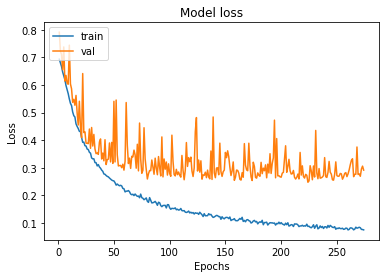

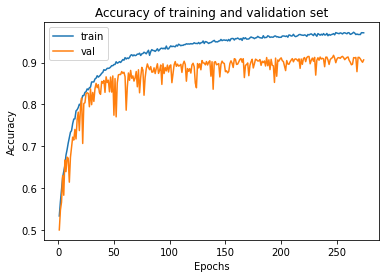

Score for: loss of 0.2914277911186218; accuracy of 90.65200090408325%
              precision    recall  f1-score   support

       grass     0.9382    0.8810    0.9087      1429
     asphalt     0.8857    0.9407    0.9124      1400

    accuracy                         0.9106      2829
   macro avg     0.9119    0.9109    0.9105      2829
weighted avg     0.9122    0.9106    0.9105      2829



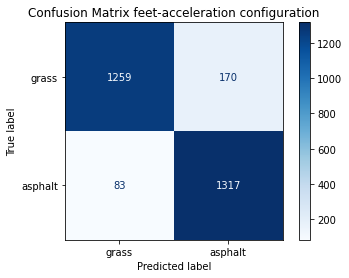

In [ ]:
model = final_model(X_train.shape[1:])

#calling model
epochs = 500
batch_size = 200

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "model", save_best_only=True, monitor="val_loss"
    ),
    # keras.callbacks.ReduceLROnPlateau(
    #     monitor="val_loss", factor=0.5, patience=20
    # ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer=Adam(lr=0.004),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(X_validation, y_validation),
    verbose=1,
)

#plot
#plot train/validation loss and train/validation accuracy 
history_dict = history.history
loss_values=history_dict['loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs,history_dict['loss'])
plt.plot(epochs, history_dict['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

accuracy_values = history_dict['accuracy']
val_accuracy= history_dict['val_accuracy']
plt.plot(epochs, accuracy_values)
plt.plot(epochs, val_accuracy)
plt.title('Accuracy of training and validation set') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#validation score
score = model.evaluate(X_validation, y_validation, verbose=0) 
print(f'Score for: {model.metrics_names[0]} of {score[0]}; {model.metrics_names[1]} of {score[1]*100}%')


#recall, f1-score, precision 
labels = ['grass', 'asphalt']
# predict_X_test = model.predict(X_test) 
# y_pred = np.argmax(predict_X_test,axis=1)

y_test_arg=np.argmax(y_test,axis=1)
Y_pred = np.argmax(model.predict(X_test),axis=1)
# print('Confusion Matrix')
# print(confusion_matrix(y_test_arg, Y_pred))
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

print(classification_report(y_test_arg, Y_pred, target_names=labels, digits=4))


#confusion matrix
confusion_matrix = confusion_matrix(y_test_arg, Y_pred)

cmd = ConfusionMatrixDisplay.from_predictions(y_test_arg,
                                              Y_pred,
                                              display_labels=labels,
                                              cmap=plt.cm.Blues)
cmd.ax_.set_title("Confusion Matrix feet-acceleration configuration")
plt.show()

# 6. 5-fold with test set

In [ ]:
X_train,y_train,X_test,y_test,X_validation, y_validation=final_prep(Foot.numpy(), ALL_Surfaces.to_numpy(), ALL_Participants_numb.to_numpy(),False)

Tensor train shape: (20368, 101, 6)
Tensor validation shape: (5092, 101, 6)
Tensor test shape: (2829, 101, 6)


In [ ]:
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam

# Define the K-fold Cross Validator
num_folds=5
inputs = X_train 
targets = y_train 
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):

  # Define the model architecture
  model = final_model(X_train.shape[1:])    

  loss_function='binary_crossentropy'
  optimizer='Adam' 
  # Compile the model
  callbacks = [
    keras.callbacks.ModelCheckpoint(
        "model", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=1),
  ]
  model.compile(loss=loss_function,
                optimizer=optimizer,
                metrics=['accuracy'])


  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  batch_size=200
  no_epochs=200
  history = model.fit(inputs[train], targets[train],
              batch_size=batch_size,
              epochs=no_epochs,
              verbose=2) 

  # Generate generalization metrics
  scores = model.evaluate(inputs[test], targets[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

  # Increase fold number
  fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/200
82/82 - 78s - loss: 0.6421 - accuracy: 0.6199 - 78s/epoch - 947ms/step
Epoch 2/200
82/82 - 74s - loss: 0.5584 - accuracy: 0.7165 - 74s/epoch - 898ms/step
Epoch 3/200
82/82 - 73s - loss: 0.4983 - accuracy: 0.7640 - 73s/epoch - 885ms/step
Epoch 4/200
82/82 - 73s - loss: 0.4473 - accuracy: 0.7946 - 73s/epoch - 887ms/step
Epoch 5/200
82/82 - 74s - loss: 0.4220 - accuracy: 0.8120 - 74s/epoch - 902ms/step
Epoch 6/200
82/82 - 72s - loss: 0.3988 - accuracy: 0.8224 - 72s/epoch - 875ms/step
Epoch 7/200
82/82 - 74s - loss: 0.3670 - accuracy: 0.8391 - 74s/epoch - 899ms/step
Epoch 8/200
82/82 - 71s - loss: 0.3601 - accuracy: 0.8424 - 71s/epoch - 865ms/step
Epoch 9/200
82/82 - 71s - loss: 0.3343 - accuracy: 0.8556 - 71s/epoch - 865ms/step
Epoch 10/200
82/82 - 71s - loss: 0.3171 - accuracy: 0.8654 - 71s/epoch - 864ms/step
Epoch 11/200
82/82 - 73s - loss: 0.3091 - accuracy: 0.8700 - 73s/epoch -